# <a id='toc1_'></a>[Geometry Optimisation with RDkit, xTB and CREST](#toc0_)

1. **A. Maghamé Foumkpou**, aissatou.maghame@facsciences-uy1.cm
     * Department of Physics, Faculty of Science, University of Yaoundé I
2. **J-P. Tchapet Njafa**, jean-pierre.tchapet-njafa@univ-maroua.cm
    * Department of Physics, Faculty of Science, University of Yaoundé I

December 2024

## Introduction

L'**optimisation de la structure géométrique** consiste à minimiser l'énergie d'un système en faisant varier les positions des atomes. Cette structure optimisée correspond généralement à une configuration stable, représentant soit un **minimum local** (une espèce stable) soit un **état de transition** (une configuration à haute énergie entre deux espèces stables) (voir image ci-après). Celle-ci permet d'obtenir une meilleure concordance entre les calculs théoriques et les mesures expérimentales.  

Dans ce tutoriel, nous utilisons les modules suivants :

 
* [RDKit](https://github.com/rdkit) (Open-Source Cheminformatics Software),
* [xTB](https://xtb-docs.readthedocs.io/en/latest/) (Semiempirical Extended Tight-Binding Program Package) et
* [CREST](https://xtb-docs.readthedocs.io/en/latest/) (Conformer-Rotamer Ensemb Tool based on the xtb Semiempirical Extended Tight-Binding Program Package) : des outils de chimie computationnelle et de modélisation moléculaire.

### Voici un aperçu de ce que fait chacun de ces modules :

**RDKit**  :
* Représentation et manipulation de molécules et de bases de données de composés chimiques ;
* Génération et optimisation de conformations ;
* Prédiction de propriétés physico-chimiques et biologiques (descripteurs).           

**XTB**  :
* Optimisation de géométrie et calcul d'énergie de molécules;
* Simulation de structures électroniques (orbitales moléculaires, charges partielles, etc.);
* Calcul de propriétés thermodynamiques (enthalpie, entropie, énergie libre);
* Analyse vibrationnelle (fréquences de vibration, modes normaux);
* Modélisation de réactions chimiques et de mécanismes réactionnels.

**CREST**  :
* Génération d'ensembles de conformères de molécules flexibles.



Ces trois modules sont très utilisés dans divers domaines de la chimie computationnelle, tels que la découverte de médicaments, la conception moléculaire, la chimie théorique, l'analyse structurale et la prédiction de propriétés.

L'objectif de ce tutoriel est d'optimiser une molécule organique hétérocyclique à partir de son SMILES (`C1=CON=C1`), d'extraire le **gap HOMO-LUMO**, puis d'effectuer les calculs HF et DFT.


## surface d’énergie potentielle (PES, potential energy surface)

 La PES est un concept important en chimie et en physique, utilisé pour décrire comment l'énergie d'un système change en fonction de ses positions et de ses configurations.

 <img src="./Graphics/PES.png" width="400"></center>

Il capture l'interaction entre les degrés de liberté électroniques et nucléaires dans un système, et les **points stationnaires** ( un **minimum local** (une espèce stable), soit un **état de transition** (une configuration à haute énergie entre deux espèces stables)) sur le PES sont importants pour élucider les conformations moléculaires et expliquer les mécanismes des réactions chimiques et photochimiques. **Les dérivées du premier (**gradient**) et du second ordre (**Hessien**) de l'énergie par rapport aux déplacements nucléaires sont des éléments clés pour localiser ces points et déterminer les voies de réaction d'énergie minimale**.


Les  **états de transition sont caractérisés par un gradient nul combiné à un Hessien qui a une et une seule valeur propre négative**.

Il existe de nombreux algorithmes  pour les optimisations d'état de transition. L'**algorithme de Newton-Raphson (NR)** efficace, mais il nécessite des dérivées secondes précises (hessienne). Le calcul des dérivées secondes est long, c'est pourquoi la plupart des codes de mécanique quantique utilisent ce qu'on appelle des méthodes **quasi-Newton** qui nécessitent uniquement un gradient précis (dérivées premières) et une hessienne approximative (estimation). Le gradient peut être calculé directement à partir de la solution SCF, donc ces méthodes quasi-Newton sont beaucoup plus rapides.


## Choix des coordonnées

Examinons le choix des coordonnées dans lesquelles ces dérivées énergétiques sont exprimées.

<img src="./Graphics/Coordinates.png" width="600"></center>


### Coordonnées cartésiennes

La manière la plus simple de définir les positions atomiques consiste à utiliser un **système de référence cartésien** et à définir chaque position atomique en termes de sa position, **(x,y,z)-coordonnées**. Dans ce système de coordonnées, il est très facile de déterminer l'énergie totale et le gradient d'énergie, mais ce choix n'est pas favorable à l'optimisation géométrique, car ces coordonnées sont fortement couplées entre elles.

### Coordonnées internes

Un choix plus avantageux consiste à travailler avec des coordonnées internes, telles que les longueurs de liaison, les angles de valence et les dièdres. L'ensemble de coordonnées internes le plus connu est la **matrice Z**, qui utilise ces propriétés pour décrire la structure moléculaire. Cependant, l'utilisation de coordonnées internes pose deux défis : 
1. le choix des coordonnées n'est pas unique et
2. les coordonnées internes doivent être reconverties en coordonnées cartésiennes pour calculer l'énergie et le gradient. 

## Optimisation orbitale

En termes pratiques, les ingrédients pour effectuer une optimisation géométrique comprennent : 

1. les coordonnées moléculaires initiales,
2. l'énergie à une géométrie spécifique $E(\mathbf{x})$,
3. le gradient $\mathbf{g}(\mathbf{x})=\nabla E(\mathbf{x})$,
4. le Hessien, et
5. une procédure pour mettre à jour les coordonnées et le Hessian et se déplacer sur la surface d’énergie potentielle vers une énergie plus faible.

### Comment ça marche ?

Les étapes d'une optimisation de la géométrie moléculaire sont illustrées dans la figure ci-dessous.

<img src="./Graphics/Geo_opt.png" width="500"></center>

1. **Entrée de géométrie initiale** : l'utilisateur fournit une première estimation de la géométrie moléculaire. Cela peut être basé sur des données expérimentales, une intuition chimique ou des résultats de calculs antérieurs, des applications comme RDKit ou Openbabel.

2. **Choix de la méthode** : Une méthode de théorique quantique (par exemple, méthodes Hartree-Fock, DFT, post-Hartree-Fock) et un ensemble de bases sont choisis en fonction du système et de la précision souhaitée.

3. **Processus itératif** : le programme de structure électronique ajuste de manière itérative les positions des atomes pour réduire l'énergie totale. Ceci est réalisé en calculant les forces exercées sur les atomes et en les utilisant pour prédire une nouvelle géométrie à plus faible énergie.

4. **Convergence** : le processus se poursuit jusqu'à ce que des changements dans la géométrie produisent des changements d'énergie négligeables (critère de convergence satisfait), indiquant qu'une structure optimisée a été trouvée.

Il est important de souligner qu'alors que l’objectif est de trouver le minimum global (la structure énergétique la plus basse absolue), en pratique, l’optimisation géométrique trouve souvent des minima locaux. Des techniques supplémentaires peuvent être nécessaires pour garantir que le minimum global a été localisé.

L'optimisation orbitale dans les méthodes de structure électronique offre les avantages suivants : 
 1. Les énergies deviennent variationnelles en ce qui concerne les rotations orbitales, il n'y a donc pas besoin de réponse orbitale lors du calcul des gradients nucléaires; 
 2. Les propriétés peuvent être calculées plus facilement car il n'y a aucune contribution de réponse orbitale aux matrices de densité; 
 3. Les pôles parasites dans les fonctions de réponse pour des méthodes inexactes telles que la théorie des grappes couplées (coupled cluster ou CC) peuvent être supprimées; 
 4. Les problèmes de rupture de symétrie peuvent être mieux décrits.


## Création du répertoire de sauvegarde des fichiers

In [1]:
from pathlib import Path  #Pour manipuler les chemins de fichiers de manière plus pratique

In [2]:
# # Définir le chemin du répertoire
data_dir = Path('./dataGeo_opt')  # Cette ligne crée un objet Path représentant le chemin du sous-répertoire 'dataGeo_opt' dans le répertoire courant (.)

# # Créer le répertoire, sans lever d'erreur si celui-ci existe déjà
data_dir.mkdir(exist_ok=True)

La ligne `data_dir.mkdir(exist_ok=True)` vérifie si le répertoire `dataGeo_opt` existe déjà. Si ce n'est pas le cas, elle crée ce répertoire.

La méthode `mkdir()` du module pathlib qui permet de créer un nouveau répertoire 

L'argument `exist_ok=True` indique que si le répertoire existe déjà, la méthode ne lève pas d'erreur et continue simplement.

## Structure géométrique initiale avec RDKit

In [3]:
#  Importons les modules et classes nécessaires

import rdkit
from rdkit import Chem #  permet de manipuler des structures chimiques
from rdkit.Chem import AllChem, Draw , MolFromSmiles 
from rdkit.Chem import MolFromSmiles # Cette fonction convertit une chaîne SMILES (Simplified Molecular Input Line Entry System)
#en un objet molécule RDKit 

rdkit.__version__

'2024.03.6'

### 2D

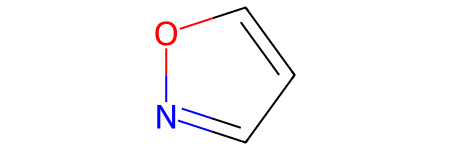

In [4]:
# Crée un objet molécule pour le Carbazole 

smile = 'C1=CON=C1' # Carbazole 
smi_key = 'Oxazole'

# Représenter la molécule à partir du smile
mol_rdkitNop = Chem.MolFromSmiles(smile) # Cette ligne utilise la fonction MolFromSmiles du module Chem de RDKit pour créer une representation mol. (mol_rdkitNop) à partir SMILES
mol_rdkitNop # affiche une représentation de la molécule oxazole

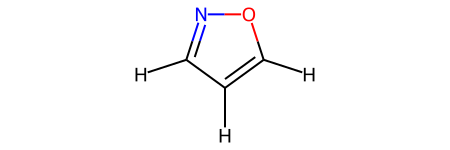

In [5]:
# Add explicit Hs
mol_rdkitNop = AllChem.AddHs(mol_rdkitNop) 
mol_rdkitNop

### Descripteurs

Caractérisent les différentes propriétés physico-chimiques de la molécule qui permettent d'évaluer la **complexité** d'une molécule en termes de sa structure chimique.

In [6]:
from rdkit.Chem import Descriptors
from rdkit.Contrib.SA_Score import sascorer

molwt = Descriptors.ExactMolWt(mol_rdkitNop)
logP = Descriptors.MolLogP(mol_rdkitNop) 
Sa_score = sascorer.calculateScore(mol_rdkitNop)
Polarity = Descriptors.TPSA(mol_rdkitNop) # Topological Polar Surface Area
Solubility = Descriptors.MolLogP(mol_rdkitNop)
hbd = Descriptors.NumHDonors(mol_rdkitNop)
hba = Descriptors.NumHAcceptors(mol_rdkitNop)

print(f'Some molecular properties are :\n Molecular weight:{molwt}, \n Solubility:{logP},  \n Sa score:{Sa_score}, \n polarity:{Polarity}, \n solubility:{logP}, \n hbd:{hbd}, \n hba:{hba}')  


Some molecular properties are :
 Molecular weight:69.021463716, 
 Solubility:0.6746,  
 Sa score:6.887978659985249, 
 polarity:26.03, 
 solubility:0.6746, 
 hbd:0, 
 hba:2


[07:24:48] DEPRECATION WARNING: please use MorganGenerator


##  Importance de chaque descripteur
  
  * **Polarity (TPSA) = 26.03 Å^2**

    - La polarité de la molécule TADF joue un rôle crucial dans le couplage spin-orbite, qui est le mécanisme clé du TADF.
    - Une polarité optimale permet de favoriser le croisement intersystème entre l'état singulet et l'état triplet, facilitant ainsi la conversion de l'état triplet    en état singulet émissif.
    - La polarité influence également les propriétés de transfert de charge dans la molécule, qui sont essentielles pour le TADF.
      
* Interprétation : Cette valeur de polarité est relativement élevée, indiquant une molécule assez polaire.
* Marge d'acceptation typique pour les molécules TADF : **20-60 Å^2**. La valeur de 26.03 Å^2 se situe donc dans la plage acceptable.

   * **Hbd (Nombre de donneurs de liaisons hydrogène) = 0**
 
 * Marge d'acceptation typique pour les molécules TADF : Hbd ≤ 2. La valeur de 0 est donc dans la plage acceptable.

    * **Hba (Nombre d'accepteurs de liaisons hydrogène) = 2**

* Marge d'acceptation typique pour les molécules TADF : Hba ≤ 6. La valeur de 6 est donc dans la plage acceptable.

    * **Solubilité (Solubility ou LogP) = 0.6746**
        Dans les dispositifs TADF, la solubilité des molécules est importante pour permettre une bonne mise en forme du matériau actif, par exemple par dépôt en solution.
       - Une bonne solubilité facilite aussi l'incorporation homogène de la molécule TADF dans la matrice hôte du dispositif.
       - Une solubilité appropriée permet d'optimiser les propriétés de transport de charges et d'émission de la couche active.
  

*    **Score de synthèse accessible (Sa score) = 6.887978659985249**
       - Le Sa score est une estimation de la facilité de synthèse d'une molécule.
      -  Pour les applications TADF, il est important de développer des molécules qui peuvent être synthétisées de manière relativement simple et peu coûteuse.
       - Un Sa score faible indique une meilleure accessibilité synthétique, ce qui est un critère important pour le développement de matériaux TADF à grande échelle.
 * Marge d'acceptation typique pour les molécules TADF : **Sa score ≤ 4,5**. La valeur de 4,5 n'est pas dans la plage acceptable.

### Structure 3D non optimisée

In [7]:
# For 3D plotting
import py3Dmol

py3Dmol.__version__

'2.0.4'

In [8]:
# Create subdirectory output
working_dir = Path(f'{data_dir}/{smi_key}')

# Create the output directory if it doesn't exist create it
working_dir.mkdir(parents=True, exist_ok=True)

#Checking
working_dir

PosixPath('dataGeo_opt/Oxazole')

In [9]:
# CLa fonction 'def' définit une fonction nommée view3D qui prend trois arguments :
def view3D(mol_rdkitNop, label, fmt='mol'):
        """3D vizualisation of mol/xyz file with Py3DMol
        """

        view = py3Dmol.view(width=400, height=400) # Cette ligne crée un objet view pour la visualisation

        if fmt=='mol':
            view.addModel(Chem.MolToMolBlock(mol_rdkitNop), fmt)
            # view.addModel(mol, fmt)
        elif fmt=='xyz':
            view.addModel(mol_rdkitNop, fmt)

        view.setStyle({'stick': {}, 'sphere': {'scale': .30}}) # Définit le style de visualisation
        view.addLabel(label, {'position': {'x': -2, 'y': -3, 'z': 0}}) # Ajoute une étiquette à la visualisation à la position spécifiée

        view.zoomTo()
        view.show()

In [10]:
# Add explicit Hs
mol_rdkitNop3D = Chem.AddHs(mol_rdkitNop)

# Generates the initial 3D conformation of the molecule
AllChem.EmbedMolecule(mol_rdkitNop3D) # génére une conformation 3D à partir d'une représentation 2D d'une molécule

# 3D visualization
view3D(mol_rdkitNop3D, f'{smi_key}_3D_Nop')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Coordonnés moléculaires initiales (coordonnées cartésiennes)

In [11]:
# Sauvegarde de cette structure non optimisée dans un fichier .xyz
path_rdkitNop_xyz = working_dir / f'{smi_key}_rdkitNop.xyz'

# Convert RDKit molecule to XYZ format 
mol_xyzNop0 = Chem.MolToXYZBlock(mol_rdkitNop3D)

with open(path_rdkitNop_xyz, "w") as f:
    f.write(mol_xyzNop0)

In [12]:
print(f'{mol_xyzNop0}')

8

C      0.000239    0.731375   -0.001986
C     -1.098566   -0.106954   -0.048413
O     -0.663602   -1.342027   -0.025757
N      0.636611   -1.360792    0.031938
C      1.125910   -0.092628    0.050169
H     -0.024063    1.798740   -0.005971
H     -2.146540    0.157849   -0.095596
H      2.170011    0.214436    0.095616



In [13]:
# Si l'on veut utiliser cette structure pour un calcul DFT, on retire les deux premières ligne

mol_xyz0 = '\n'.join(mol_xyzNop0.strip().split('\n')[2:])

print(mol_xyz0)

C      0.000239    0.731375   -0.001986
C     -1.098566   -0.106954   -0.048413
O     -0.663602   -1.342027   -0.025757
N      0.636611   -1.360792    0.031938
C      1.125910   -0.092628    0.050169
H     -0.024063    1.798740   -0.005971
H     -2.146540    0.157849   -0.095596
H      2.170011    0.214436    0.095616


## Pré-optimisation avec MMFF94s et visualisation de la structure 3D


**Champs de force empiriques** :
* AMBER (Assisted Model Building with Energy Refinement): Développé pour les biomolécules (protéines, acides nucléiques), mais aussi utilisé pour d'autres molécules organiques;
* CHARMM (Chemistry at HARvard Macromolecular Mechanics): Initialement développé pour les biomolécules, mais étendu à d'autres systèmes;
* OPLS (Optimized Potentials for Liquid Simulations): Optimisé pour la simulation de liquides et de solutions;
* UFF (Universal Force Field): Champ de force généraliste, applicable à une large gamme de molécules.

**Champs de force semi-empiriques**:
* MMFF (Merck Molecular Force Field): Famille de champs de force développés par Merck, avec différentes variantes comme MMFF94 et MMFF94s;
* CFF (Consistent Force Field): Champ de force développé pour les molécules organiques;
* MM3/MM4: Versions améliorées du champ de force MM2 original.

**Champs de force ab initio**:
* AMOEBA (Atomic Multipole Optimized Energetics for Biomolecular Applications): Champ de force polarisable, avec une meilleure description des interactions électrostatiques
* QM/MM (Quantum Mechanics/Molecular Mechanics): Approche hybride combinant des méthodes de mécanique quantique (QM) et de mécanique moléculaire (MM).

Nous utilisons une méthode d'optimisation basée sur le champs de force **MMFF94s** car très performant, parametré specifiquement pour les molecules organiques et largement utilisé en chimie computationnelle, grâce à sa précision améliorée et à son domaine d'application étendu.

In [14]:
# Optimizes the 3D conformation of the molecule using MMFF - Merck Molecular Force Field
mol_rdkitOp3D = mol_rdkitNop3D
AllChem.MMFFOptimizeMolecule(mol_rdkitOp3D, maxIters = 450, mmffVariant = "MMFF94s")

#Canonicalize the orientation of the conformation
Chem.rdMolTransforms.CanonicalizeMol(mol_rdkitOp3D, normalizeCovar=True, ignoreHs=False)

# 3D visualization
view3D(mol_rdkitOp3D, f'{smi_key} RDKit Molecule MMFF94s')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [15]:
# Sauvegarde de cette structure non optimisée dans un fichier .xyz
path_rdkitOp_xyz = working_dir / f'{smi_key}_rdkitOp.xyz'

# Convert RDKit molecule to XYZ format 
mol_xyzOp0 = Chem.MolToXYZBlock(mol_rdkitOp3D)

with open(path_rdkitOp_xyz, "w") as f:
    f.write(mol_xyzOp0)

In [16]:
print(f'{mol_xyzOp0}')

8

C     -0.014374    0.781778   -0.000003
C     -1.093227   -0.063202    0.000001
O     -0.663568   -1.350275   -0.000003
N      0.723247   -1.369134   -0.000002
C      1.091846   -0.085769   -0.000001
H     -0.025098    1.860610   -0.000003
H     -2.164534    0.071505    0.000005
H      2.145709    0.154488    0.000005



In [17]:
mol_xyz1 = '\n'.join(mol_xyzOp0.strip().split('\n')[2:])

print(mol_xyz1)

C     -0.014374    0.781778   -0.000003
C     -1.093227   -0.063202    0.000001
O     -0.663568   -1.350275   -0.000003
N      0.723247   -1.369134   -0.000002
C      1.091846   -0.085769   -0.000001
H     -0.025098    1.860610   -0.000003
H     -2.164534    0.071505    0.000005
H      2.145709    0.154488    0.000005


## Calcul du RMSD (Root Mean Square Deviation) 
C'est une mesure statistique qui quantifie la différence moyenne entre deux conformations d'une même molécule ou entre une structure expérimentale et une structure prédite.

In [19]:
AllChem.AlignMol(AllChem.MolFromXYZBlock(mol_xyzNop0),AllChem.MolFromXYZBlock(mol_xyzOp0))

0.059407921868628956

* **Le RMSD est inférieure à 2/3 Å** ce qui pourrait indiquer que le système a convergé vers une structure plus stable
* On note une faible différence entre les deux structures moléculaires. 

## Optimisation de la structure 3D avec xTB et CREST : introduction sur les methodes xTB

**xtb** implémente des méthodes de calcul quantique semi-empiriques avancées, telles que GFN1-xTB, GFN2-xTB et IPEA-xTB qui permettent d'effectuer des calculs d'énergie, d'optimisation de géométrie, de fréquences vibrationnelles et d'autres propriétés moléculaires de manière rapide et efficace.


<img src="./Graphics/Bon_xtb.jpeg" width="500"></center>


**CREST** optimise les conformères générés en minimisant leur énergie et en éliminant les structures redondantes ou non-physiques. Cela conduit à un ensemble réduit de conformères stables et représentatifs.


In [20]:
#  Common packages
import os  # Utilisé pour des opérations comme la création, la suppression, ou la modification de fichiers et répertoires
from sys import exit # terminer et quitter   un programme 
import subprocess as sp # 

In [21]:
#Fonction pour nettoyer les fichiers de calcul
def clean_xtb_files():
        #---------------------------------------------------------------------
        # Clean up output files from xtb, xtb-stda and CREST processes
        #FIXME To call after each xtb function
        #---------------------------------------------------------------------
        sp.run(['rm', 'bondlengths', 'charges', 'coord', 'coord.original', 'cregen_0.tmp','spec.dat','rots.dat',
                'cregen_1.tmp', 'cre_members', 'crest_best.xyz', 'crest_conformers.xyz', 'vibspectrum', 'hessian', 'g98.out',
                'crest.energies', 'crest_rotamers.xyz', 'gfnff_charges', 'gfnff_topo', 'wfn.xtb', 'xtbhess.xyz',
                '.history.xyz', 'struc.xyz', 'wbo', 'xtbopt.xyz', 'xtbopt.log', '.xtboptok', 'crest_property.xyz',
                'xtbrestart', 'xtbtopo.mol', 'xtblast.xyz', 'gfnff_adjacency', '.UHF', 'tda.dat',
                'ensemble_energies.log', 'charges3', 'charges', 'molden.input', 'crest_0.mdrestart',
                'crest_dynamics.trj', 'crestopt.log', 'crest.restart', 'crest_input_copy.xyz'], stdout=sp.DEVNULL, stderr=sp.DEVNULL)
        # For folder
        sp.run(['rm', '-r', 'calculation.level.1'], stdout=sp.DEVNULL, stderr=sp.DEVNULL)

Il est possible d'exécuter xTB en ligne, sur [atomistica](https://atomistica-online-xtb.anvil.app/).

### Vérification des versions de xTB, CREST et sTDA installées

In [22]:
try:
  import xtb, crest
except:
  %pip install xtb crest -U
  import xtb, crest

In [23]:
!xtb --version

      -----------------------------------------------------------      
     |                   =====================                   |     
     |                           x T B                           |     
     |                   =====================                   |     
     |                         S. Grimme                         |     
     |          Mulliken Center for Theoretical Chemistry        |     
     |                    University of Bonn                     |     
      -----------------------------------------------------------      

   * xtb version 6.6.1 (8d0f1dd) compiled by 'conda@1efc2f54142f' on 2023-08-01

normal termination of xtb


In [24]:
!crest --version

 
       ╔════════════════════════════════════════════╗
       ║            ___ ___ ___ ___ _____           ║
       ║           / __| _ \ __/ __|_   _|          ║
       ║          | (__|   / _|\__ \ | |            ║
       ║           \___|_|_\___|___/ |_|            ║
       ║                                            ║
       ║  Conformer-Rotamer Ensemble Sampling Tool  ║
       ║          based on the xTB methods          ║
       ║                                            ║
       ╚════════════════════════════════════════════╝
       Version 3.0.1, Mon May  6 18:43:33 UTC 2024
       commit (1782d7d) compiled by 'runner@fv-az772-53'
 
 crest 3.0.1


## Pré-optimisation avec xTB sur la molécule pré-optimisée avec RDKit

## Définition des chemins pour les fichiers xtb de pré-optimisation, les fichiers xtb d'optimisation et le fichier journal CREST

In [25]:
# Setting various paths for xtb and crest files
#pré-optimisation with xtb
path_xtb_xyzProp = working_dir / f'{smi_key}_xtb_PrOpt.xyz'
path_xtb_logProp = working_dir / f'{smi_key}_xtb_PrOpt.log'

#optimisation with xtb
path_xtb_xyzOp = working_dir / f'{smi_key}_xtb_Opt.xyz'
path_xtb_logOp = working_dir / f'{smi_key}_xtb_Opt.log'

#log for crest
path_crest_log = working_dir / f'{smi_key}_crest.log'

path_xtb_csv = working_dir / f'{smi_key}_xtb.csv'

### Pré-optimisation avec xTB sur la molécule optimisée par RDKit

## Méthodes GFN-xTB et GFN-FF

**GFN-xTB** (Geometry, Frequency, Noncovalent - xTight Binding) est une méthode semi-empirique performante pour la modélisation de propriétés moléculaires. Elle utilise des paramètres ajustés à partir de données expérimentales. Cela permet d'obtenir des résultats précis à un coût de calcul raisonnable, par rapport aux méthodes ab initio plus coûteuses.


<img src="./Graphics/XTB.gif" width="500"></center>

  * Différentes variantes :
        GFN0-xTB, GFN1-xTB et GFN2-xTB sont les trois principales variantes, avec une complexité et une précision croissantes.

   * Propriétés ciblées : GFN-xTB vise à fournir des résultats fiables pour des propriétés telles que les géométries moléculaires, les fréquences de vibration, les énergies d'interaction, etc. La méthode est particulièrement adaptée pour la modélisation de systèmes moléculaires de taille moyenne à grande.
    
          
**GFN-FF**  (Geometry, Frequency, Noncovalent Force Field) est une approche hybride qui combine les avantages de GFN-xTB et des champs de force classiques, permettant la modélisation de systèmes moléculaires de grande taille.


La méthode **GFN2-xTB** se distingue par sa capacité à fournir des résultats de très haute qualité pour un coût de calcul relativement faible, la rendant particulièrement adaptée pour la modélisation de systèmes moléculaires complexes à grande échelle.

In [26]:
!xtb {path_rdkitOp_xyz} --gfn 2 --opt vtight --parallel 4 > {path_xtb_logProp}

normal termination of xtb
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


* La commande ci-dessus lance une optimisation de géométrie avec la méthode GFN2-xTB, en utilisant des critères de convergence très stricts et en tirant parti du calcul parallélisé sur 2 cœurs. Les résultats de ce calcul seront enregistrés dans le fichier journal {path_xtb_logProp}.

* L'option **--opt vtight** permet de définir des critères de convergence très stricts pour l'optimisation de la géométrie moléculaire. Ces critères de convergence très stricts permettent d'obtenir une optimisation de géométrie très précise, au détriment d'un temps de calcul généralement plus long que pour une optimisation **standard (--opt tight)**.

#### Sauvegarde de la structure pré-optimisée

In [27]:
!cp xtbopt.xyz {path_xtb_xyzProp}

## Visualisation de la structure pre-optimisée par xtb

In [28]:
#Visualisation
molecule_xtb_preOp = path_xtb_xyzProp.read_text()
lines = molecule_xtb_preOp.strip().split('\n')
molecule_xtb_preOp = '\n'.join(lines[:1] + [''] + lines[2:])

view3D(molecule_xtb_preOp, f'{smi_key} Pre. Opt Molecule xTB', fmt='xyz')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Recherche du meilleur conformère avec CREST

Le code ci-dessous lance une analyse conformationnelle avec CREST en utilisant la méthode GFN2-xTB, avec des paramètres d'échantillonnage rapides et sans vérification de la topologie de référence. Les résultats seront enregistrés dans le fichier de sortie {path_crest_log}.


{path_xtb_xyzProp} : C'est le chemin du fichier d'entrée au format XYZ contenant la structure moléculaire à analyser. 
*  --mquick : Cette option active le mode "rapide" de CREST, qui utilise des paramètres d'échantillonnage plus agressifs pour accélérer les calculs;

* --noreftopo : Cette option désactive la vérification de la topologie de référence, ce qui peut être utile lorsque la structure d'entrée n'a pas de topologie de référence connue.

* -T 2 : Cette option définit le nombre de threads (cœurs de processeur) à utiliser pour les calculs en parallèle.


In [ ]:
!crest {path_xtb_xyzProp} --gfn 2 --mquick --noreftopo -T 4 {path_crest_log}

 
       ╔════════════════════════════════════════════╗
       ║            ___ ___ ___ ___ _____           ║
       ║           / __| _ \ __/ __|_   _|          ║
       ║          | (__|   / _|\__ \ | |            ║
       ║           \___|_|_\___|___/ |_|            ║
       ║                                            ║
       ║  Conformer-Rotamer Ensemble Sampling Tool  ║
       ║          based on the xTB methods          ║
       ║                                            ║
       ╚════════════════════════════════════════════╝
       Version 3.0.1, Mon May  6 18:43:33 UTC 2024
       commit (1782d7d) compiled by 'runner@fv-az772-53'
 
   Cite work conducted with this code as

   • P.Pracht, F.Bohle, S.Grimme, PCCP, 2020, 22, 7169-7192.
   • S.Grimme, JCTC, 2019, 15, 2847-2862.
   • P.Pracht, S.Grimme, C.Bannwarth, F.Bohle, S.Ehlert,
     G.Feldmann, J.Gorges, M.Müller, T.Neudecker, C.Plett,
     S.Spicher, P.Steinbach, P.Wesołowski, F.Zeller,
     J. Chem. Phys., 2024, 160, 11

### Optimisation avec xTB sur le meilleur conformère de la molécule

In [ ]:
!xtb crest_best.xyz --gfn 2 --opt vtight --parallel 4 > {path_xtb_logOp}

In [ ]:
# Sauvegarde de la structure Optimisée
!cp xtbopt.xyz {path_xtb_xyzOp}

In [ ]:
#Visualisation
molecule_xtb_Op = path_xtb_xyzOp.read_text()
lines = molecule_xtb_Op.strip().split('\n')
molecule_xtb_Op = '\n'.join(lines[:1] + [''] + lines[2:])

view3D(molecule_xtb_Op, f'{smi_key} Optimized Molecule xTB', fmt='xyz')

In [ ]:
# Read the XYZ file
mol_xtb_xyz = path_xtb_xyzOp.read_text()
lines =mol_xtb_xyz.strip().split('\n')
mol_xtb_xyz = '\n'.join(lines[:1] + [''] + lines[2:])

view3D(mol_xtb_xyz, f'{smi_key} xTB Molecule', fmt='xyz')

In [ ]:
#Nettoyage des fichiers
clean_xtb_files()

## Calcul du RMSD (Root Mean Square Deviation) 

In [ ]:
AllChem.AlignMol(AllChem.MolFromXYZBlock(mol_xyzNop0),AllChem.MolFromXYZBlock(mol_xtb_xyz))

### Visualisation des trois structures non optimisée , pré-optimisée par RDkit et optimisée par xTB

In [ ]:
# Create the viewer object
viewer = py3Dmol.view(viewergrid=(1, 3), width=300*3, height=250, linked=True)

# Add the molecules to the viewer
viewer.addModel(Chem.MolToMolBlock(mol_rdkitNop3D), 'mol', viewer=(0, 0))
viewer.addModel(Chem.MolToMolBlock(mol_rdkitOp3D), 'mol', viewer=(0, 1))
viewer.addModel(mol_xtb_xyz, "xyz", viewer=(0, 2))

# Set the view style
viewer.setStyle({"stick": {}, "sphere": {"scale": 0.25}})
viewer.setViewStyle({"style": "outline", "width": 0.05})

# Add legends for each molecule
viewer.addLabel('RDKit Molecule', {'position': {'x': -2, 'y': -3, 'z': 0}}, viewer=(0, 0))
viewer.addLabel('RDKit Molecule MMFF94', {'position': {'x': -4, 'y': -3, 'z': 0}}, viewer=(0, 1))
viewer.addLabel('xTB Molecule', {'position': {'x': -2, 'y': -3, 'z': 0}}, viewer=(0, 2))

# Adjust the zoom level
viewer.zoomTo()

# Display the viewer
viewer.show()

### Extraction du gap HOMO-LUMO


### Gap HOMO-LUMO et gap énergétique

Le **gap HOMO-LUMO** et le **gap énergétique** sont deux concepts liés mais distincts en chimie et physique moléculaire.

<img src="./Graphics/slide_20.jpg" width="1000"></center>

**Gap HOMO-LUMO** :
* Le gap HOMO-LUMO fait référence à la différence d'énergie entre l'orbitale moléculaire occupée la plus haute (HOMO) et l'orbitale moléculaire inoccupée la plus basse (LUMO);
* Il s'agit d'une propriété fondamentale d'une molécule qui détermine en partie sa réactivité chimique et ses propriétés électroniques;
* Un gap HOMO-LUMO important indique généralement une molécule plus stable et moins réactive.
       

**Gap énergétique** :
* Le gap énergétique fait référence à la différence d'énergie entre deux niveaux d'énergie d'un système, comme par exemple entre la bande de valence et la bande de conduction dans un solide.
* Dans le cas des molécules, le gap énergétique peut correspondre à la différence d'énergie entre différents états électroniques de la molécule, comme l'état fondamental et un état excité.
* Le gap énergétique est une propriété importante qui détermine les propriétés optiques, électriques et photophysiques d'un matériau ou d'une molécule.
* Le gap énergétique peut être mesuré expérimentalement par des techniques spectroscopiques, ou calculé théoriquement à l'aide de méthodes de chimie quantique.

In [ ]:
#---------------------------------------------------------------------
# Extract the total energy and Homo-lumo gap from the xtb log file
#---------------------------------------------------------------------
# Find HOMO-LUMO GAP value
# HL_gap_line = [li for li in path_xtb_logOp.read_text().splitlines() if 'HOMO-LUMO GAP' in li]
# HL_gap_line = HL_gap_line[0].split()
# HL_gap_xtb = float(HL_gap_line[3])

# print(f'Le gap HOMO-LUMO vaut {HL_gap_xtb} eV')

In [ ]:
#---------------------------------------------------------------------
# Extract the total energy and Homo-lumo gap from the xtb output file
#---------------------------------------------------------------------
# Find TOTAL ENERGY value
tot_energy_line = [li for li in path_xtb_logOp.read_text().splitlines() if 'TOTAL ENERGY' in li]
tot_energy_line = tot_energy_line[0].split()
tot_energy_xtb = float(tot_energy_line[3])

# Find HOMO-LUMO GAP value
HL_gap_line = [li for li in path_xtb_logOp.read_text().splitlines() if 'HOMO-LUMO GAP' in li]
HL_gap_line = HL_gap_line[0].split()
HL_gap_xtb = float(HL_gap_line[3])

# Find HOMO index
Homo_idx_line = [li for li in path_xtb_logOp.read_text().splitlines() if '(HOMO)' in li]
Homo_idx_line = Homo_idx_line[0].split()
Homo_idx_xtb = int(Homo_idx_line[0])

# Find LUMO index
Lumo_idx_line = [li for li in path_xtb_logOp.read_text().splitlines() if '(LUMO)' in li]
Lumo_idx_line = Lumo_idx_line[0].split()
Lumo_idx_xtb = int(Lumo_idx_line[0])

In [ ]:
import pandas as pd

# Create the xtb results dataframe
df_xtb = pd.DataFrame({'xtb calc':[HL_gap_xtb, tot_energy_xtb, Homo_idx_xtb, Lumo_idx_xtb]}, 
index=["HOMO-LUMO GAP (eV)","TOTAL ENERGY (a.u.)", "HOMO Index", "LUMO Index"])

# Save the xtb results dataframe to a file
with open(path_xtb_csv, "w") as f:
    f.write(f"\n\nxtb calculations of {smi_key}  \n")
    df_xtb.to_csv(f)
    
df_xtb

*  **0 eV ≤ HOMO-LUMO GAP ≤ 5 eV** ce résultat de calcul xtb montre que la molécule peut etre considerer comme un **semi-conducteur** et est favorable à l'émission de la lumière visible, respectivement du bleu au rouge.

### Calcul du champ moyen HF

A l'issue de ce calcul, nous avons l'énergie de référence SCF. 

#### Choix de l'ensemble de base 

Nous allons d'abord effectuer le choix de l'ensemble de base nous donnant le meilleur compromis précision de la valeur de l'énergie et temps de calculs.

In [ ]:
import time, datetime

from pyscf import gto, scf 


In [ ]:

# Convert mol_rdkit object to Pyscf Mol objects
mol_xyz = '\n'.join(mol_xtb_xyz.strip().split('\n')[2:])

mol_pyscf = gto.Mole(
    atom=mol_xyz,
    charge=0,
    spin = 0,
    symmetry = True,
    unit = 'Angstrom')

In [ ]:
basis_sets = [
    "6-31G",            # Double zeta with 6 Gaussian primitives
    "6-31G*",           # Double zeta with 6 Gaussian primitives
    "6-31G(d,p)",       # Double zeta with 6 Gaussian primitives with polarization functions and diffuse functions
    "6-311G(d,p)",      # Triple zeta with polarization functions
    "def2-SVP",         # Double zeta with polarization functions
    "def2-SVPD",        # Double zeta with polarization functions and diffuse functions
    "def2-TZVP",        # Triple zeta with polarization functions
    "def2-TZVPD",       # Triple zeta with polarization functions and diffuse functions
    "def2-TZVPP"        # Triple zeta with polarization functions and diffuse functions
]

In [ ]:
# To write output results of mf.analysis on a file
# path_HF_basis_log = working_dir / f'{smi_key}_HF_basis.log'
# mol_pyscf.output = path_HF_basis_log

mf_energies = list()
mf_times = list()
nb_prim = list()

# Perform a Mean-Field calculation for each basis set
for bs in basis_sets:

    # Measure execution time
    start = time.time()
    mol_pyscf.basis = bs
    mol_pyscf.build()

    mf = scf.RHF(mol_pyscf) # Create a PySCF HF mean-field object
    mf.x2c().density_fit() # To speed up calculations
    mf.kernel()
    end = time.time()

    nb_prim.append(mol_pyscf.npgto_nr())
    mf_energies.append(mf.e_tot)
    mf_times.append(end-start)

In [ ]:
# Create the results dataframe

df_HF = pd.DataFrame({"Basis":basis_sets, 
                      'Nb of GTO primitives':nb_prim, 
                      'Total energy (a.u.)':mf_energies,
                      "Time (s)":mf_times})

df_HF


In [ ]:
import matplotlib.pyplot as plt

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(8,5))

# Plot the energies.
ax.set_xticks(range(len(basis_sets)), basis_sets, rotation=45)
ax.set_xlabel("Basis set")
ax.set_ylabel("Energy / Hartree", color="b")
ax.scatter(range(len(basis_sets)), mf_energies, marker="o", s=50, color="b")

# Plot the time to solution
ax_time = ax.twinx()
ax_time.scatter(range(len(basis_sets)), mf_times, marker="s", s=50, color="r")
ax_time.set_ylabel("Time to solution / s", color="r", rotation=270, va="bottom")

# Show the graph
plt.tick_params(axis="both", direction="in")
plt.show()

In [ ]:
print(f'Le nombre total d\'électrons est {mol_pyscf.nelectron} et le nombre total d\'électrons (alpha, béta) est {mol_pyscf.nelec}')
print(f'Le nombre d\'orbitales atomiques, dans la base {mol_pyscf.basis}, est {mol_pyscf.nao_nr()}')
print(f'L\'énergie nucléaire vaut {mol_pyscf.energy_nuc()} Hartrees')

## Calculons l'energie Hartree-Fock (HF)

In [ ]:
from pyscf import scf

In [ ]:
import time
start_hf = time.time()
myhf = scf.RHF(mol_pyscf).run()
hf_energy = myhf.e_tot
hf_time = time.time() - start_hf

print("Énergie totale HF :", hf_energy)
print("Temps de calcul HF :", hf_time, "secondes")


In [ ]:
myhf.mo_occ #- Occupation MO (vecteur de longueur égale au nombre de MO)

In [ ]:
lumo_idx = myhf.mo_occ.tolist().index(0.)
homo_idx = lumo_idx - 1
print(f'Les indexes du (HOMO,LUMO) sont {homo_idx,lumo_idx}')

##   Calcul DFT

In [ ]:
from pyscf import dft

In [ ]:
start_myks = time.time()
myks = dft.RKS(mol_pyscf, xc="B3LYP").run()
myks_time = time.time() - start_myks

print("Énergie totale DFT :", myks.e_tot)
print("Temps de calcul DFT :", myks_time, "secondes")